In [ ]:
!rm -rf *
!git config --global user.name "Akhilez"
!git config --global user.email "akhild18@yahoo.com"
!git clone https://github.com/Akhilez/ml_gallery.git
%cd ml_gallery/ml_py

Cloning into 'ml_gallery'...
remote: Enumerating objects: 551, done.
remote: Counting objects: 100% (551/551), done.
remote: Compressing objects: 100% (380/380), done.
remote: Total 2078 (delta 329), reused 345 (delta 157), pack-reused 1527
Receiving objects: 100% (2078/2078), 11.71 MiB | 7.23 MiB/s, done.
Resolving deltas: 100% (1267/1267), done.
/content/ml_gallery/ml_py


In [ ]:
import os
os.environ['SECRET_KEY'] = '1234'
%mkdir -p data/mnist/numbers

In [ ]:
import torch
from torch.nn.functional import relu
from collections import namedtuple
from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
aug = MNISTAug()
dm = DataManager()
dm.load()
aug.max_objects = 10
aug.min_objects = 4

Extracting /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw/train-images-idx3-ubyte.gz to /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw


Extracting /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw/train-labels-idx1-ubyte.gz to /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw


Extracting /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw


Extracting /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw
Processing...
Done!




/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
x_train, y_train = aug.get_augmented(dm.x_train, dm.y_train, 10)
x_test, y_test = aug.get_augmented(dm.x_test, dm.y_test, 2)

In [ ]:
x_train = torch.tensor(x_train.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')
x_test = torch.tensor(x_test.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')

[{'class': 3,
  'class_one_hot': tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  'cx': 51.0,
  'cy': 46.0,
  'height': 42,
  'width': 42,
  'x1': 30,
  'x2': 72,
  'y1': 25,
  'y2': 67},
 {'class': 8,
  'class_one_hot': tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  'cx': 21.0,
  'cy': 52.0,
  'height': 30,
  'width': 30,
  'x1': 6,
  'x2': 36,
  'y1': 37,
  'y2': 67},
 {'class': 6,
  'class_one_hot': tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  'cx': 88.0,
  'cy': 78.5,
  'height': 53,
  'width': 48,
  'x1': 64,
  'x2': 112,
  'y1': 52,
  'y2': 105},
 {'class': 0,
  'class_one_hot': tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'cx': 90.0,
  'cy': 44.0,
  'height': 38,
  'width': 38,
  'x1': 71,
  'x2': 109,
  'y1': 25,
  'y2': 63},
 {'class': 2,
  'class_one_hot': tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  'cx': 73.5,
  'cy': 23.5,
  'height': 19,
  'width': 19,
  'x1': 64,
  'x2': 83,
  'y1': 14,
  'y2': 33},
 {'class': 8,
  'class_one_hot': tensor([0.

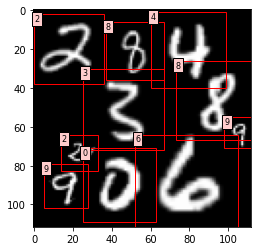

In [ ]:
DataManager.plot_num(x_train[0].reshape((112, 112)), y_train[0])
y_train[0]

In [ ]:
# 14 * 14  = 196 anchor boxes
# side of each anchor box = 28

n_anchors = 14 * 14

anchor_grid_spacing = 8

anchor_centers = []
for i in range(14):
  anchor_row = []
  for j in range(14):
    anchor_row.append([
      j * anchor_grid_spacing + anchor_grid_spacing / 2,
      i * anchor_grid_spacing + anchor_grid_spacing / 2,
    ])
  anchor_centers.append(anchor_row)
anchor_centers = torch.tensor(anchor_centers)

In [ ]:
anchor_centers.shape

torch.Size([14, 14, 2])

In [ ]:
class BoxPredictor(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = torch.nn.Linear(4096, 1024)
    self.linear2 = torch.nn.Linear(1024, 3 * n_anchors)

  def forward(self, x):
    x = relu(self.linear1(x))
    x = torch.tanh(self.linear2(x))
    return x


class ConfidencePredictor(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = torch.nn.Linear(4096, 1024)
    self.linear2 = torch.nn.Linear(1024, 2 * n_anchors)

  def forward(self, x):
    x = relu(self.linear1(x))
    x = torch.nn.functional.softmax(self.linear2(x).reshape((-1, n_anchors, 2)), 2)
    return x


class DetectorV1 (torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, padding=1)  # 112x112
        self.conv2 = torch.nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 56x56
        self.conv3 = torch.nn.Conv2d(64, 128, 3, stride=2, padding=1)  # 28x28
        self.conv4 = torch.nn.Conv2d(128, 256, 3, stride=2, padding=1)  # 14x14
        self.conv5 = torch.nn.Conv2d(256, 512, 3, stride=2, padding=1)  # 7x7
        self.linear1 = torch.nn.Linear(25088, 4096)
        self.box_predictor = BoxPredictor()
        self.confidence_predictor = ConfidencePredictor()

    def forward(self, x):
        x = relu(self.conv1(x))  # 112
        x = relu(self.conv2(x))  # 56
        x = relu(self.conv3(x))  # 28
        x = relu(self.conv4(x))  # 14
        x = relu(self.conv5(x))  # 7
        x = torch.flatten(x, 1)
        x = relu(self.linear1(x))
        boxes = self.box_predictor(x)
        confidences = self.confidence_predictor(x)
        return boxes, confidences

model = DetectorV1().to(device)
optimizer = torch.optim.Adam(model.parameters())

Steps:
 - get the predictions.
 - Find the anchors which have >0.1 IoU -> +ve anchors
 - Find the matching bounding box for each +ve anchor
 - All +ve anchors are high confidence, rest are low.
 - What is the loss for -ve anchors?

In [ ]:
epochs = 2
batch_size = 5

for epoch in range(epochs):
    
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index].to(device)
        y_batch = y_d[start_index:end_index].to(device)
        
        optimizer.zero_grad()

        y_hat = model(x_batch)

        positive_anchors = get_positive_anchors(y_hat, y_batch)

        loss = sum(sum((y_batch - y_hat)**2))
        
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch}, loss={float(loss)}')

In [ ]:
def get_positive_anchors(y_hat, y_batch):
  """
  1. For Each item in the batch:
  2. For each anchor box:
    - For each bounding box:
      - Find the IoU.
    - Pick bounding box with highest IoU
    - If highest IoU is < 0.3, then continue 1.
    # - Create the difference units for the anchor and the bounding box as y
    - Now add the anchor box and bounding box into a map.

  for i in range()
  return [{
      1: 3
  }]
  """

In [ ]:
def units_to_diff(y):
    y_d = []
    for i in range(len(y)):
      yi_d = []
      for j in range(len(y[i])):
        cx_d = (y[i][j]['cx'] - anchor_centers[i][j][0]) / 112
        cy_d = (y[i][j]['cy'] - anchor_centers[i][j][1]) / 112
        w_d = (y[i][j]['width'] - 28) / 112
        yi_d.append((cx_d, cy_d, w_d))
      y_d.append(yi_d)
    return y_d

def diff_to_units(y):
    y_units = []
    for i in range(len(y)):
        cx_d = y[i][0] * 112 + anchor_cx
        cy_d = y[i][1] * 112 + anchor_cy
        wd = y[i][2] * 112 + anchor_w
        y_units.append((cx_d, cy_d, wd))
    return torch.tensor(y_units)